<h2>Лабораторная работа №4</h2>
<h3>студента группы 6212</h3>
<h3>Зазвонова Ильи</h3>

Делаем необходимые импорты и объявляем константы

In [3]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import nltk


from nltk.corpus import stopwords
from pymystem3 import Mystem
from nltk.probability import FreqDist


PATH_TO_ANNOTATION = "c:\\Users\\Acer\\Documents\\py_lab_2\\annotations_2.csv"

Функция для создания датафрема по аннотации

In [4]:
def create_dataframe(annotation_path: str) -> pd.DataFrame:
    df = pd.DataFrame(columns=["Тип рецензии", "Текст рецензии", "Количество слов"])
    with open(annotation_path, mode="r", encoding="utf-8") as ann:
        for line in ann.readlines():
            line = line.split(",")
            with open(line[0], mode="r", encoding="utf-8") as file:
                film_name = file.readline().rstrip()
                text = "\n".join(file.readlines())
                row = pd.Series({'Тип рецензии': line[2].rstrip(),'Текст рецензии': text,'Количество слов': len(text.split(" "))}, name = film_name)
                df_new_row = pd.DataFrame([row], columns=df.columns)
                df = pd.concat([df, df_new_row])
    df.dropna()
    return df


df = create_dataframe(PATH_TO_ANNOTATION)
print(df)

     Тип рецензии                                     Текст рецензии  \
Тьма          bad  Вчера, наконец, досмотрела «Тьму». Сразу скажу...   
Тьма          bad  Я пишу данное ревью исключительно потому, что ...   
Тьма          bad  Не буду описывать содержание, нет смысла. Сраз...   
Тьма          bad  Никогда такого не было, и вот опять...\n\n\n\n...   
Тьма          bad  О данном сериале я услышал совсем недавно, и у...   
...           ...                                                ...   
1+1          good  Начну с того, что фильм у нас в стране показал...   
1+1          good  Легкость. Казалось бы, её не может быть ни у ч...   
1+1          good  Без всяких предисловий сразу скажу, что это хо...   
1+1          good  Большинство французский фильмов всегда наполне...   
1+1          good  Похоже, это один из самых добрых и человечных ...   

     Количество слов  
Тьма             667  
Тьма             625  
Тьма             527  
Тьма             337  
Тьма             817

Функция, вычисляющая статистические данные для числовых полей датафрейма  и функция группировки датафрейма с с вычислением максимального, минимального и среднего значения по количеству слов

In [8]:
def get_static_info(df: pd.DataFrame) -> pd.DataFrame:
    return df["Количество слов"].describe()


def stats_for_marks(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop('Текст рецензии', axis=1)
    df = df.groupby('Тип рецензии')

    df_max = df.max().values.tolist()
    df_min = df.min().values.tolist()
    df_mean = df.mean().values.tolist()

    df_max = sum(df_max, [])
    df_min = sum(df_min, [])
    df_mean = sum(df_mean, [])

    result = pd.DataFrame({'Тип рецензии': ['bad', 'good']})
    result["max"] = df_max
    result["min"] = df_min
    result["mean"] = df_mean
    
    return result


print(get_static_info(df))
stats_for_marks(df)

count     2000
unique     659
top        215
freq        15
Name: Количество слов, dtype: int64


,Тип рецензии,max,min,mean
0,bad,1617,34,369.247
1,good,999,24,329.530


Функции сортировки датафрейма по словам и по меткам

In [9]:
def sort_dataframe_by_word_count(df: pd.DataFrame, count: int) -> pd.DataFrame:
    return df[df["Количество слов"] <= count]


def sort_dataframe_by_mark(df: pd.DataFrame, mark: str) -> pd.DataFrame:
    return df[df["Тип рецензии"] == mark]


sort_dataframe_by_mark(df, "bad")

,Тип рецензии,Текст рецензии,Количество слов
Тьма,bad,"Вчера, наконец, досмотрела «Тьму». Сразу скажу...",667
Тьма,bad,"Я пишу данное ревью исключительно потому, что ...",625
Тьма,bad,"Не буду описывать содержание, нет смысла. Сраз...",527
Тьма,bad,"Никогда такого не было, и вот опять...\n\n\n\n...",337
Тьма,bad,"О данном сериале я услышал совсем недавно, и у...",817
...,...,...,...
Гордость и предубеждение,bad,По одному из спутниковых каналов недавно показ...,240
Гордость и предубеждение,bad,"'Гордость и тщеславие - разные вещи, хотя этим...",399
Гордость и предубеждение,bad,"Прочитав книгу, а затем уже посмотрев фильм 20...",259
Гордость и предубеждение,bad,И постигло меня большое разочарование... Ведь ...,432


Функция создания диаграммы частотного анализа слов со вспомогательными функциями

In [5]:
def list_to_dict(a: list, b: dict) -> dict:
    """Функция преобразования списка в словарь"""
    for i in a:
        if i in b.keys():
            b[i] +=1
        else:
            b[i] =1
    return b


def del_trash(text: str) -> str:

    ALF = [x for x in "абвгдеёжзийклмнопрстуфхцчшщъыьэюя " + "абвгдеёжзийклмнопрстуфхцчшщъыьэюя".upper()]

    res = ''
    for i in text:
        if i in ALF:
            res += i
    return res


def merge(a: dict, b: FreqDist) -> None:
    """Слияние словаря с FreqDist с изменением исходного словаря"""
    for key, value in b.items():
        if key in a.keys():
            a[key] += value
        else:
            a[key] = value


def dict_to_FreqDist(a: dict) -> FreqDist:
    """Преобразует словарь в FreqDist"""
    b = FreqDist()
    for key, value in a.items():
        b[key] = value
    return b



def process(text: str, m: Mystem, stopwords_ru: list, d: dict, n: int, nlp) -> None:
    """Здесь происходят основные вычисления функции get_hist"""
    text = del_trash(text)
    l = [word for word in m.lemmatize(text) if (word not in stopwords_ru) and nlp(word)[0].pos_ not in ["VERB", "NOUN"]]
    processed = FreqDist(nltk.Text(l)).most_common(n)
    merge(d, dict(processed))




In [14]:
def get_hist(df: pd.DataFrame, mark: str, n: int) -> pd.Series:
    d = FreqDist()
    m = Mystem()

    nlp = spacy.load("ru_core_news_md")

    stopwords_ru = set(stopwords.words("russian"))
    stopwords_ru = stopwords_ru | {'серия', 'фильм', 'сезон', 'сериал', 'который', 'первый', "второй", "персонаж", " ", '  ', "   "}
    stopwords_ru = stopwords_ru | {*tuple(nlp.Defaults.stop_words)}
    stopwords_ru = stopwords_ru | {word.lower() for word in df.index}
    

    i = 0

    for text in sort_dataframe_by_mark(df, mark)['Текст рецензии']:
        i+=1
        print(i)
        text = del_trash(text)
        l = [word for word in m.lemmatize(text) if (word not in stopwords_ru) and nlp(word)[0].pos_ not in ["VERB", "NOUN"]]
        merge(d, FreqDist(nltk.Text(l)))
        d = dict_to_FreqDist(dict(d.most_common(round(n))))
    print(d.most_common(n))
    return pd.Series(dict(d.most_common(n)))


hist = get_hist(df, "bad", 20)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Функция, визуализирующая гистограмму

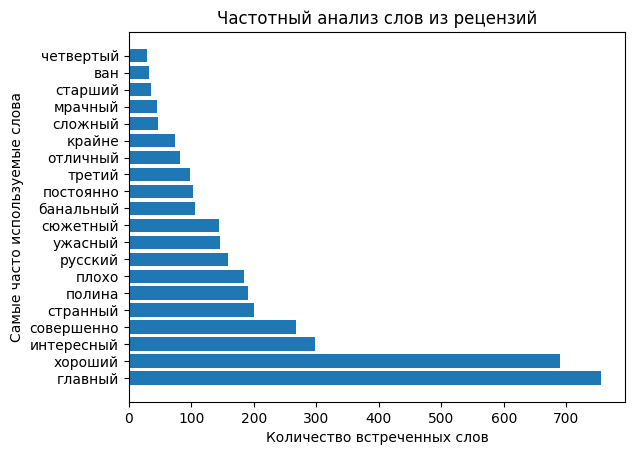

In [15]:
def show_barh(df: pd.Series) -> None:
    plt.barh(df.index, df.values)
    plt.xlabel("Количество встреченных слов")
    plt.ylabel("Самые часто используемые слова")
    plt.title("Частотный анализ слов из рецензий")
    plt.show()


show_barh(hist)